# What is an Autoencoder?

What happens if instead of classifying the input data we try to reconstruct it?

That is, what happens if we train the Neural Network to learn to generate the same input data as output?

In this case we will have an Autoencoder!

Elements of Autoenconder:
* An encoder that allows input data to be compressed
* The bottleneck (or bottleneck, result of compression) which is the compact representation obtained **(latent space and is the result of training, where the network learns to extract the most relevant information from the input data)**
* And the decoder, which reconstructs the input from the bottleneck


### Training of the Autoencoder

In order to achieve this compact representation, the Autoencoder is trained in a similar way to a Neural Network.

However, in this case the error function used to update the autoencoder coefficients is simply the result of comparing, point by point, the reconstructed data with the original data.
Taking this into account we can say that the Autoencoder is an example of unsupervised learning, because during training we do not really define the category to which each input belongs, because what we want is for the output to be exactly the same input data, but this is the real definition about it: autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data.


### Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [2]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [3]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

As well as the decoder model:

In [4]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3816 - val_loss: 0.1898
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1802 - val_loss: 0.1546
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1502 - val_loss: 0.1347
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1323 - val_loss: 0.1213
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1202 - val_loss: 0.1124
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1122 - val_loss: 0.1064
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - val_loss: 0.1024
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1027 - val_loss: 0.0993
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0999 - val_loss: 0.0972
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0982 - val_loss: 0.0958
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0968 - val_loss: 0.0949
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


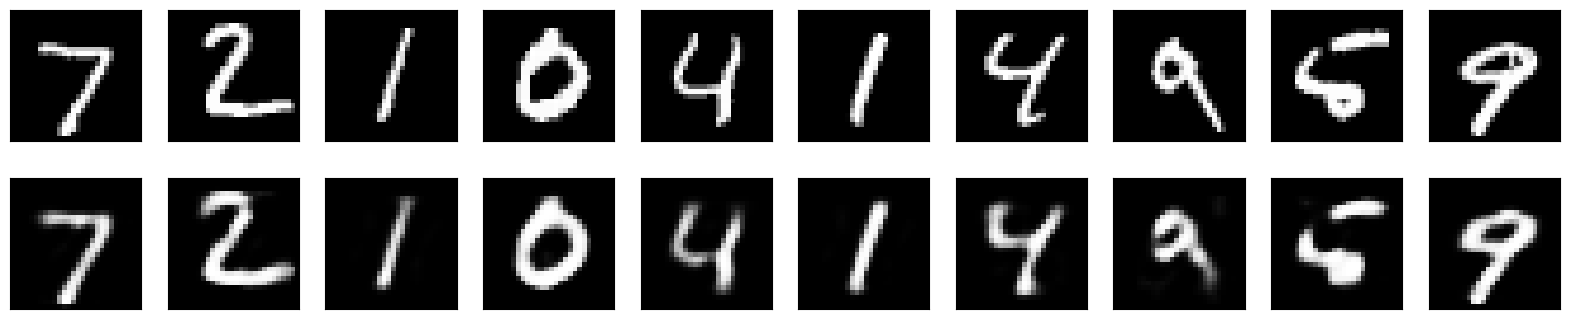

In [9]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep autoencoder
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [10]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3391 - val_loss: 0.1686
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1591 - val_loss: 0.1351
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1323 - val_loss: 0.1219
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1216 - val_loss: 0.1154
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1148 - val_loss: 0.1106
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1111 - val_loss: 0.1076
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1081 - val_loss: 0.1047
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1052 - val_loss: 0.1024
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1031 - val_loss: 0.1007
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1013 - val_loss: 0.0992
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1000 - val_loss: 0.0978
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


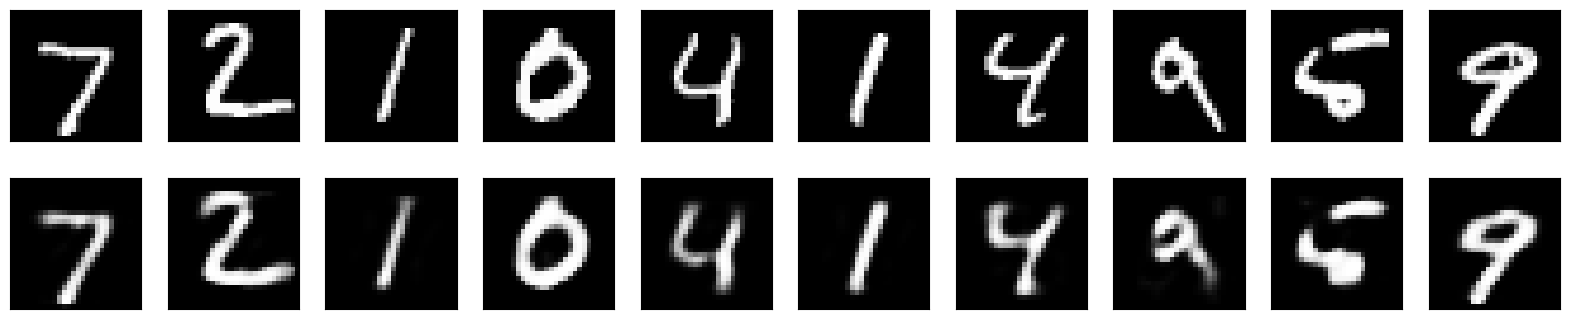

In [14]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()